# Environment Setup

In [ ]:
# Might need to run these in Jupyter the first time this is run for sksurv 
# !pip install cmake
# !pip install scikit-survival

In [54]:
from imp import reload
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
from skimage.transform import resize
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.metrics import concordance_index_censored
from sksurv.nonparametric import kaplan_meier_estimator
import sys
import tensorflow as tf 
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Dropout, Input, MaxPool2D
from tensorflow.keras.optimizers import Adam
import tensorflow.compat.v2.summary as summary
from tensorflow.python.ops import summary_ops_v2
from tqdm import tqdm
from typing import Any, Dict, Iterable, Sequence, Tuple, Optional, Union


In [5]:
# sys.path.append(".")
from patient_data_split import pat_train_test_split
from input_function import InputFunction, _make_riskset
import cph_loss
import cindex_metric
from train_and_evaluate import TrainAndEvaluateModel

In [ ]:
# pip install import_ipynb

# Data Loading and Setup

In [6]:
# Constants for development
FILESTOLOAD = 2888 # 2888 is all of them
imdim_from_preprocessing = 256 # must match opt.ImageSize in image preprocessing configuration files
imdim_for_network = 256
random_seed = 16

In [8]:
# Path to CSVs that connect patient id to slices and rfs label
zero_info_path = "/Users/katyscott/Documents/ICC/Data/Labels/" + str(imdim_from_preprocessing) +"/RFS_all_tumors_zero.csv"
nan_info_path = "/Users/katyscott/Documents/ICC/Data/Labels/" + str(imdim_from_preprocessing) +"/RFS_all_tumors_NaN.csv"

zero_image_path = '/Users/katyscott/Documents/ICC/Data/Images/Tumors/' + str(imdim_from_preprocessing) + '/Zero/'
nan_image_path = '/Users/katyscott/Documents/ICC/Data/Images/Tumors/' + str(imdim_from_preprocessing) + '/NaN/'


In [9]:
# Reading in info for zero background images
info = pd.read_csv(zero_info_path)
image_fnames = np.asarray(info.iloc[:, 0])
pat_num = np.asarray(info.iloc[:, 1])
slice_num = np.asarray(info.iloc[:, 2])
rfs_event = np.asarray(info.iloc[:, 3])
rfs_time = np.asarray(info.iloc[:, 4])

print(rfs_event.shape)
print(rfs_time[1])

(2888,)
0.6


In [10]:
info.rename(columns={"Pat ID": "Pat_ID", "Slice Num": "Slice_Num", "RFS Code": "RFS_Code", "RFS Time":"RFS_Time"}, inplace=True)

In [11]:
# Only loading in 100 number of files for development
images = np.empty((1,imdim_for_network,imdim_for_network))
file_count = 0
for image_file in tqdm(image_fnames):
    if file_count >= FILESTOLOAD:
        break
    else:
        file_count += 1
    #     print("Loading: ", image_file)
        # Load in file as an numpy array
        img = np.fromfile(zero_image_path + image_file)
        # Reshape image from 1D to 2D array - need to nothardcode this, square root?
        img_2D = np.reshape(img, (imdim_from_preprocessing,imdim_from_preprocessing))
        # Scale image to this dimension, smooth image with Gaussian filter, pads with the reflection of the vector
        # mirrored on the first and last values of the vector along each axis.
        img_final = resize(img_2D, (imdim_for_network, imdim_for_network), anti_aliasing=True, mode='reflect')
        # Not sure this next line is working, want an array with all the images as their own array in it
        img_final_3D = np.reshape(img_final, (1,) + img_final.shape)
        images = np.append(images, img_final_3D, axis=0)

images = np.delete(images, 0, axis=0)

100%|██████████| 2888/2888 [1:06:52<00:00,  1.39s/it]   


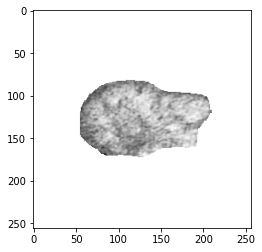

In [12]:
# Confirming images loaded in properly
plt.imshow(images[8], cmap='Greys')

## Splitting data for training/testing

In [13]:
# Training and testing split
split = 0.9
train_slice_indices, test_slice_indices = pat_train_test_split(pat_num[:FILESTOLOAD], rfs_event[:FILESTOLOAD], 0.9, random_seed)

print("Train: ", np.array(train_slice_indices).shape)
print("Test: ", np.array(test_slice_indices).shape)

Train:  (2938,)
Test:  (305,)


In [16]:
train_slices = images[train_slice_indices,:,:]#[:][:]
train_slices = train_slices.squeeze() # Remove first dim of size 1

train_time = rfs_time[train_slice_indices]
train_event = rfs_event[train_slice_indices]
print("Training set: ", train_slices.shape)
print("Training time labels: ", train_time.shape)
print("Training event labels: ", train_event.shape)

test_slices = images[test_slice_indices,:,:]
test_slices = test_slices.squeeze() # Remove first dim of size 1

test_time = rfs_time[test_slice_indices]
test_event = rfs_event[test_slice_indices]
print("Testing set: ", test_slices.shape)
print("Testing time labels: ", test_time.shape)
print("Testing event labels: ", test_event.shape)


Training set:  (2938, 256, 256)
Training time labels:  (2938,)
Training event labels:  (2938,)
Testing set:  (305, 256, 256)
Testing time labels:  (305,)
Testing event labels:  (305,)


## Linear Regression Analysis

In [ ]:
train_1D = np.reshape(train_slices, (train_slices.shape[0], train_slices.shape[1]*train_slices.shape[2]))
test_1D = np.reshape(test_slices, (test_slices.shape[0], test_slices.shape[1]*test_slices.shape[2]))
# train_1D = train_1D[0:100,:]
# linreg_labels = train_event[0:100]
print(train_1D.shape)
print(test_1D.shape)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score


regression_model = LinearRegression().fit(train_1D, train_event)
regression_model.score(test_1D, test_event)

## Data Exploration

In [ ]:
# Distribution plots for slice level labels, total dataset
slice_rfs_code_plt = sns.displot(info, x="RFS_Code")
plt.xticks([0,1])
plt.xlabel("RFS Code")
plt.title("Slice RFS Code")

slice_rfs_time_plt = sns.displot(info, x="RFS_Time")
plt.xlabel("RFS Time (months)")
plt.title("Slice RFS Time")

# Distribution plots for patient level labels, total dataset
pat_info = info.drop_duplicates("Pat_ID")
pat_rfs_code_plt = sns.displot(pat_info, x="RFS_Code")
plt.xticks([0,1])
plt.xlabel("RFS Code")
plt.title("Patient RFS Code")

pat_rfs_time_plt = sns.displot(pat_info, x="RFS_Time", )
plt.xlabel("RFS Time (months)")
plt.title("Patient RFS Time")

In [ ]:
# Getting label info for train and testing sets
training_info = info.iloc[train_slice_indices[0]]
testing_info = info.iloc[test_slice_indices[0]]

# Distribution plots for slice level labels, training set
trainslice_rfs_code_plt = sns.displot(training_info, x="RFS_Code")
plt.xticks([0,1])
plt.xlabel("RFS Code")
plt.title("Training Set - Slice RFS Code")

trainslice_rfs_time_plt = sns.displot(training_info, x="RFS_Time")
plt.xlabel("RFS Time (months)")
plt.title("Training Set - Slice RFS Time")

# Distribution plots for patient level labels, training set
train_pat_info = training_info.drop_duplicates("Pat_ID")
trainpat_rfs_code_plt = sns.displot(train_pat_info, x="RFS_Code")
plt.xticks([0,1])
plt.xlabel("RFS Code")
plt.title("Training Set - Patient RFS Code")

trainpat_rfs_time_plt = sns.displot(train_pat_info, x="RFS_Time", )
plt.xlabel("RFS Time (months)")
plt.title("Training Set - Patient RFS Time")

# Distribution plots for slice level labels, testing set
testslice_rfs_code_plt = sns.displot(testing_info, x="RFS_Code")
plt.xticks([0,1])
plt.xlabel("RFS Code")
plt.title("Testing Set - Slice RFS Code")

testslice_rfs_time_plt = sns.displot(testing_info, x="RFS_Time")
plt.xlabel("RFS Time (months)")
plt.title("Testing Set - Slice RFS Time")

# Distribution plots for patient level labels, testing set
test_pat_info = testing_info.drop_duplicates("Pat_ID")
trainpat_rfs_code_plt = sns.displot(test_pat_info, x="RFS_Code")
plt.xticks([0,1])
plt.xlabel("RFS Code")
plt.title("Testing Set - Patient RFS Code")

testpat_rfs_time_plt = sns.displot(test_pat_info, x="RFS_Time", )
plt.xlabel("RFS Time (months)")
plt.title("Testing Set - Patient RFS Time")


Text(0.5, 1.0, 'Kaplan-Meier Survival Curve')

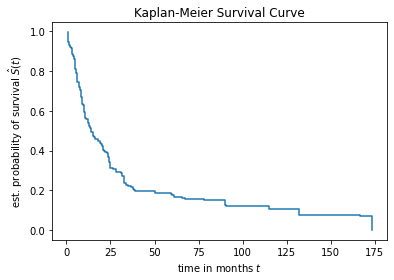

In [18]:
# Convert rfs_event from numeric to boolean for use in sksurv
b_rfs_event = np.array(rfs_event, dtype=bool)
# Creating structured array for kaplan_meier_estimator
rfs_type = np.dtype([('Status','bool'), ('Time', 'f')])
rfs = np.empty(len(rfs_event),dtype=rfs_type)
rfs['Status'] = b_rfs_event
rfs['Time'] = rfs_time

time, survival_prob = kaplan_meier_estimator(rfs['Status'], rfs['Time'])
plt.step(time, survival_prob, where="post")
plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time in months $t$")
plt.title("Kaplan-Meier Survival Curve")

# Model Setup

## Survival Analysis for Deep Learning tutorial - Sebastian Pölsterl

https://k-d-w.org/blog/2019/07/survival-analysis-for-deep-learning/

Tensorflow 2 version of code

https://nbviewer.jupyter.org/github/sebp/survival-cnn-estimator/blob/master/tutorial_tf2.ipynb

In [19]:
model = Sequential([
        Conv2D(6, kernel_size=(5,5), activation='relu', name='conv_1'),
        MaxPool2D(pool_size=(2,2)),
        Conv2D(16, (5,5), activation='relu', name='conv_2'),
        MaxPool2D(pool_size=(2,2)),
        Flatten(),
        Dense(120, activation='relu', name='dense_1'),
        Dense(84, activation='relu', name='dense_2'),
        Dense(1, activation='linear', name='dense_3')
    ])

In [20]:
howmany = 2
small_train = train_slices[:howmany]
small_time = train_time[:howmany]
small_event = train_event[:howmany]

small_test = test_slices[:howmany]
small_test_time = test_time[:howmany]
small_test_event = test_event[:howmany]

In [58]:
import input_function
import cph_loss
reload(input_function)
reload(cph_loss)
from input_function import InputFunction, _make_riskset

In [59]:
train_fn = InputFunction(small_train, small_time, small_event, drop_last = True, shuffle=True)

eval_fn = InputFunction(small_test, small_test_time, small_test_event)

trainer = TrainAndEvaluateModel(
    model=model,
    model_dir="/Users/katyscott/Documents/ICC/small-cnn/",
    train_dataset=train_fn(),
    eval_dataset=eval_fn(),
    learning_rate=0.0001,
    num_epochs=15,
)

In [49]:
# %load_ext tensorboard
os.environ['TENSORBOARD_BINARY']='/Users/katyscott/Documents/ICC/venv/bin/tensorboard'

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
%tensorboard --logdir /Users/katyscott/Documents/ICC/small-cnn/

In [60]:
trainer.train_and_evaluate()

AssertionError: in user code:

    /Users/katyscott/Documents/ICC/Code/train_and_evaluate.py:118 evaluate_one_step  *
        val_loss = self.loss_fn(y_true=[y_event, y_riskset], y_pred=val_logits)
    /Users/katyscott/Documents/ICC/Code/cph_loss.py:297 call  *
        assert rr.shape.as_list() == predictions.shape.as_list()

    AssertionError: 


## DeepConvSurv 
(Zhu, Yao, & Huang, 2016)

https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=7822579&casa_token=gVFzncUVfTgAAAAA:hGgPWCTzS2pUnsFG8xEZzZe7lAIupB_Z7SkKDnFJbilFmX1W6Ge5qCipPjiqCynL1lfSs64bVV4

In [ ]:
img_in = Input(shape=(imdim_for_network, imdim_for_network,1))

network = Conv2D(filters=32, kernel_size=686, activation='relu', padding='valid')(img_in)
network = MaxPool2D(pool_size=(2,2))(network)

network = Conv2D(filters=32, kernel_size=88, activation='relu', padding='valid')(network)
network = Conv2D(filters=32, kernel_size=43, activation='relu', padding='valid')(network)

network = MaxPool2D(pool_size=(2,2))(network)

network = Flatten()(network)
network = Dense(32, activation='relu')(network)
output = Dense(1, activation='exponential')(network)

model = Model(inputs=img_in, outputs=output, name="deepconvsurv")
model.compile(
        optimizer = Adam(),
        loss='binary_crossentropy'
)
model.summary()

## Model Training

In [ ]:
print("Training model: " + model.name)

epochs = 10
batch_size = 32

history = model.fit(x = train_slices,
                    y = train_labels,
                    batch_size = batch_size,
                    validation_split = 0.15,
                    epochs = epochs,
                    verbose = 1 
                    )

In [ ]:
# Create AUC metric vs. epoch plot
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title('model accuracy - ' + model.name)
plt.ylabel('AUC')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()